In [73]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy
import scipy.stats
import math
#from pandas_profiling import ProfileReport

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import KFold



In [76]:
df_raw=pd.read_csv('/Users/jkchandalia/Data/house-prices-advanced-regression-techniques/train.csv')

df_test_raw=pd.read_csv('/Users/jkchandalia/Data/house-prices-advanced-regression-techniques/test.csv')

In [208]:
#df_test_raw

In [4]:
def prepDataset(df):
    df=df.astype({'MSSubClass': 'category'})
    df=df.drop(axis=1,labels="Id")
    df['LotFrontage_na']=df['LotFrontage'].isna().astype("int")
    df.LotFrontage=df.LotFrontage.fillna(0)
    df.MasVnrArea=df.MasVnrArea.fillna(0)
    df.GarageYrBlt[df.GarageYrBlt.isna()]=df.YearRemodAdd[df.GarageYrBlt.isna()]
    df_explode=pd.get_dummies(df,dummy_na=True)
    return df_explode

def removeOutliers(df, y_col, min_cutoff, max_cutoff, scale="log"):
    if scale=="log":
        df = df[np.log(df[y_col])<max_cutoff]
        df = df[np.log(df[y_col])>min_cutoff]
    else:
        df = df[df[y_col]<max_cutoff]
        df = df[df[y_col]>min_cutoff]
    df = df.reset_index(drop=True)
    return df
    
def transformY(y):
    return np.log(y)

def transformYPred(y_pred):
    return np.exp(y_pred)


In [131]:
def matchTestTrain(X_train, df_test):
    X_test = X_train.iloc[0:0].append(df_test)[X_train.columns]
    X_test.fillna(0, inplace=True)
    return X_test

def fillInfZeroVals(y_pred):
    masked_y_pred = np.ma.array(y_pred, mask=~np.isfinite(y_pred))
    max_val = np.ma.max(masked_y_pred, fill_value=-np.inf)

    masked_y_pred = np.ma.array(y_pred, mask=(y_pred<=0))
    min_val = np.ma.min(masked_y_pred, fill_value=np.inf)
    y_pred[y_pred<=0]=min_val
    y_pred[y_pred==np.inf]=max_val
    return y_pred

def output_result(id_vals, y_pred, label='2'):
    result = pd.DataFrame({'Id': id_vals, "SalePrice":y_pred})
    result.to_csv("/Users/jkchandalia/Data/result"+label+".csv", index=False)

In [116]:
ranregr = RandomForestRegressor(random_state=0)
regr = LinearRegression()
lregr = Lasso(random_state=0, max_iter = 5000)
rregr = Ridge(random_state=0, max_iter = 5000)
eregr = ElasticNet(random_state=0, max_iter=5000)

lregrCV = LassoCV(random_state=0)
rregrCV = RidgeCV()
eregrCV = ElasticNetCV(random_state=0)


alpha_range=[.001, .003, .006, .008, .01, .012, .1]
model_dict = {"linear": {"model": regr}, 
              "lasso": {"model": lregr, 
                        "params":{"alpha": alpha_range}},
              "ridge": {"model": rregr, 
                        "params":{"alpha": alpha_range}},
              "random forest": {"model": ranregr,
                        "params":{"max_depth": [2,4,5,10,20]}},
             "elasticnet": {"model": eregr,
                           "params": {"alpha":alpha_range}}}

In [121]:
#Data prep
print(len(df_raw))
#df_train = removeOutliers(df_raw,'SalePrice', 10.7, 13.5)
print(len(df_train))
df_train = prepDataset(df_raw)
y = df_train.SalePrice
X = df_train.drop('SalePrice', axis=1)

scaler = StandardScaler()
#scaler.fit(X_train)

kf = KFold(n_splits=5)
kf.get_n_splits(X)



1460
1453


/Users/jkchandalia/Research/workspace/venv/vmain/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


5

In [122]:
results = []
for model_type in list(model_dict.keys()):
    print(model_type)
    current_model_dict = model_dict[model_type]
    model = current_model_dict["model"]
    for i, (train_index, validate_index) in enumerate(kf.split(X)):
        #print(validate_index[0:10])
        X_train, X_validate = X.loc[train_index,:], X.loc[validate_index,:]
        y_train, y_validate = y[train_index], y[validate_index]
        X_validate = matchTestTrain(X_train, X_validate)
        scaler.fit(X_train)
        if "params" in current_model_dict.keys():
            for param in current_model_dict["params"].keys():
                for param_val in current_model_dict["params"][param]:
                    param_dict = {param: param_val}
                    #print(param_dict)
                    model.set_params(**param_dict)
                    model.fit(scaler.transform(X_train), np.log(y_train))
                    y_pred = model.predict(scaler.transform(X_validate))
                    #y_pred = fillInfZeroVals(y_pred)
                    #print(y_pred)
                    try:
                        output = np.sqrt(metrics.mean_squared_error(y_validate,np.exp(y_pred)))
                        #print(output)
                    except ValueError:
                        output = np.nan
                    results.append([model_type, i, param_val, output])
        else:
            model.fit(scaler.transform(X_train), np.log(y_train))
            y_pred = model.predict(scaler.transform(X_validate))
            try:
                output = np.sqrt(metrics.mean_squared_error(y_validate,np.exp(y_pred)))
                #print(output)
            except ValueError:
                output = np.nan
            results.append([model_type, i, None, output])
        
        
        
        
        


linear


/Users/jkchandalia/Research/workspace/venv/vmain/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jkchandalia/Research/workspace/venv/vmain/lib/python3.6/site-packages/ipykernel_launcher.py:29: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/Users/jkchandalia/Research/workspace/venv/vmain/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/Users/jkchandalia/Research/workspace/venv/vmain/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jkchandalia/Research/workspace/venv

lasso


/Users/jkchandalia/Research/workspace/venv/vmain/lib/python3.6/site-packages/ipykernel_launcher.py:19: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/Users/jkchandalia/Research/workspace/venv/vmain/lib/python3.6/site-packages/ipykernel_launcher.py:18: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/Users/jkchandalia/Research/workspace/venv/vmain/lib/python3.6/site-packages/ipykernel_launcher.py:19: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/Users/jkchandalia/Research/workspace/venv/vmain/lib/python3.6/site-packages/ipykernel_launcher.py:18: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/Users/jkchandalia/Research/workspace/venv/vmain/lib/python3.6/site-packages/ipykernel_launcher.py:19: DataConversionWarning

/Users/jkchandalia/Research/workspace/venv/vmain/lib/python3.6/site-packages/ipykernel_launcher.py:19: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/Users/jkchandalia/Research/workspace/venv/vmain/lib/python3.6/site-packages/ipykernel_launcher.py:18: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/Users/jkchandalia/Research/workspace/venv/vmain/lib/python3.6/site-packages/ipykernel_launcher.py:19: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/Users/jkchandalia/Research/workspace/venv/vmain/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jkchandalia/Research/workspace/venv/vmain/lib/python3.6/site-packages/ipyker

ridge


/Users/jkchandalia/Research/workspace/venv/vmain/lib/python3.6/site-packages/ipykernel_launcher.py:19: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/Users/jkchandalia/Research/workspace/venv/vmain/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jkchandalia/Research/workspace/venv/vmain/lib/python3.6/site-packages/ipykernel_launcher.py:18: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/Users/jkchandalia/Research/workspace/venv/vmain/lib/python3.6/site-packages/ipykernel_launcher.py:19: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/Users/jkchandalia/Research/workspace/venv/vmain/lib/python3.6/site-packages/ipyker

random forest


/Users/jkchandalia/Research/workspace/venv/vmain/lib/python3.6/site-packages/ipykernel_launcher.py:19: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/Users/jkchandalia/Research/workspace/venv/vmain/lib/python3.6/site-packages/ipykernel_launcher.py:18: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/Users/jkchandalia/Research/workspace/venv/vmain/lib/python3.6/site-packages/ipykernel_launcher.py:19: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/Users/jkchandalia/Research/workspace/venv/vmain/lib/python3.6/site-packages/ipykernel_launcher.py:18: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/Users/jkchandalia/Research/workspace/venv/vmain/lib/python3.6/site-packages/ipykernel_launcher.py:19: DataConversionWarning

/Users/jkchandalia/Research/workspace/venv/vmain/lib/python3.6/site-packages/ipykernel_launcher.py:19: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/Users/jkchandalia/Research/workspace/venv/vmain/lib/python3.6/site-packages/ipykernel_launcher.py:18: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/Users/jkchandalia/Research/workspace/venv/vmain/lib/python3.6/site-packages/ipykernel_launcher.py:19: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/Users/jkchandalia/Research/workspace/venv/vmain/lib/python3.6/site-packages/ipykernel_launcher.py:18: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/Users/jkchandalia/Research/workspace/venv/vmain/lib/python3.6/site-packages/ipykernel_launcher.py:19: DataConversionWarning

elasticnet


/Users/jkchandalia/Research/workspace/venv/vmain/lib/python3.6/site-packages/ipykernel_launcher.py:19: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/Users/jkchandalia/Research/workspace/venv/vmain/lib/python3.6/site-packages/ipykernel_launcher.py:18: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/Users/jkchandalia/Research/workspace/venv/vmain/lib/python3.6/site-packages/ipykernel_launcher.py:19: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/Users/jkchandalia/Research/workspace/venv/vmain/lib/python3.6/site-packages/ipykernel_launcher.py:18: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/Users/jkchandalia/Research/workspace/venv/vmain/lib/python3.6/site-packages/ipykernel_launcher.py:19: DataConversionWarning

/Users/jkchandalia/Research/workspace/venv/vmain/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jkchandalia/Research/workspace/venv/vmain/lib/python3.6/site-packages/ipykernel_launcher.py:18: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/Users/jkchandalia/Research/workspace/venv/vmain/lib/python3.6/site-packages/ipykernel_launcher.py:19: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/Users/jkchandalia/Research/workspace/venv/vmain/lib/python3.6/site-packages/ipykernel_launcher.py:18: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/Users/jkchandalia/Research/workspace/venv/vmain/lib/python3.6/site-packages/ipyker

In [123]:
results
df_results = pd.DataFrame(results)
df_results.columns =  ["model", "fold", "parameter", "mse"]

In [140]:
df_results.to_csv("/Users/jkchandalia/workspace/explore-data/housing/results.csv")
#df_results.iloc[5:,:].set_index(['model','parameter']).unstack()
#df_results.pivot(columns='fold')

In [138]:
df_test = prepDataset(df_test_raw)
X_test = matchTestTrain(X, df_test)
X_test.fillna(0, inplace=True)
lregr = Lasso(random_state=0, max_iter = 5000, alpha = 0.01)
lregr.fit(scaler.fit_transform(X),np.log(y))
y_pred = transformYPred(lregr.predict(scaler.transform(X_test)))

/Users/jkchandalia/Research/workspace/venv/vmain/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/jkchandalia/Research/workspace/venv/vmain/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/jkchandalia/Research/workspace/venv/vmain/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jkchandalia/Research/worksp

In [139]:
output_result(df_test_raw.Id, y_pred,label="3")

In [78]:
#EDA
#profile = ProfileReport(df_train, title='Pandas Profiling Report')

In [8]:
profile

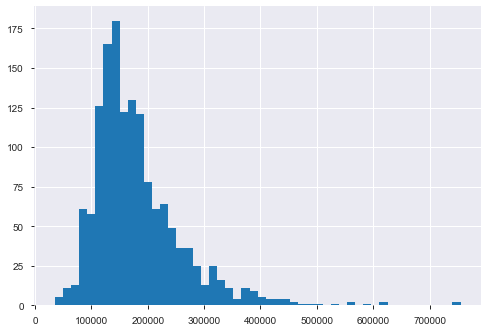

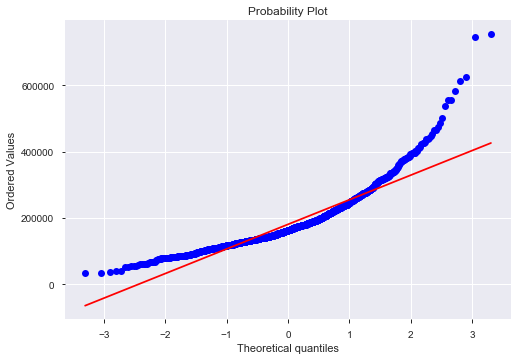

In [61]:
plt.hist(df_train.SalePrice,50)
fig = plt.figure()
ax = fig.add_subplot(111)
scipy.stats.probplot(df_train.SalePrice, sparams=(), dist='norm', fit=True, rvalue=False, plot=ax)
plt.show()


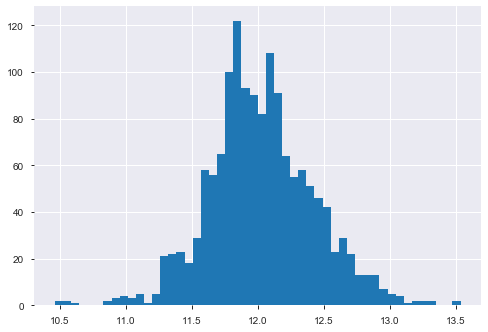

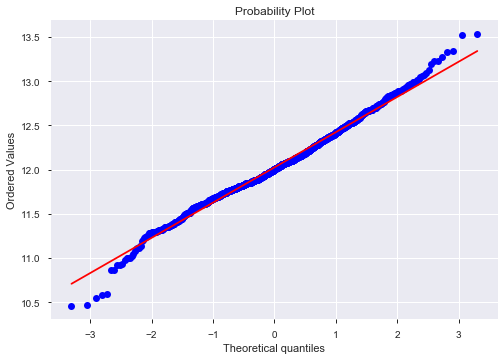

In [73]:
plt.hist(np.log(df_train.SalePrice),50)
fig = plt.figure()
ax = fig.add_subplot(111)
res = scipy.stats.probplot(np.log(df_train.SalePrice), sparams=(), dist='norm', fit=True, rvalue=False, plot=ax)
plt.show()


In [91]:
boxcox(df_train.SalePrice)


(array([7.93261046, 7.87826333, 7.95961804, ..., 8.02738182, 7.78100579,
        7.79588702]), -0.07692391328663316)

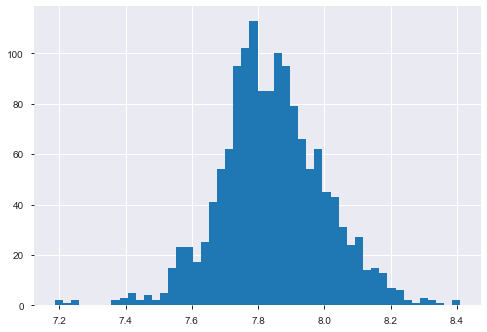

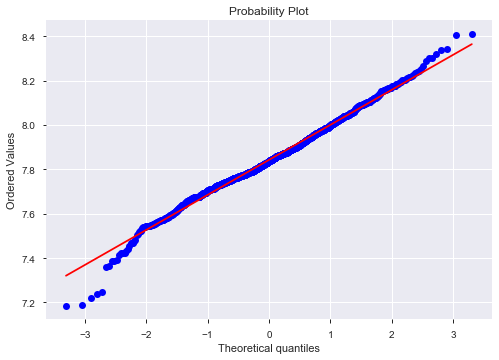

In [92]:
from scipy.stats import boxcox
plt.hist(boxcox(df_train.SalePrice)[0],50)
fig = plt.figure()
ax = fig.add_subplot(111)
res = scipy.stats.probplot(boxcox(df_train.SalePrice)[0], sparams=(), dist='norm', fit=True, rvalue=False, plot=ax)
plt.show()


In [85]:
sorted(np.log(df_train.SalePrice), reverse=True)




[13.534473028231162,
 13.521139497361697,
 13.345506928718539,
 13.323926946863102,
 13.275827535915461,
 13.229567991666638,
 13.226723392728571,
 13.195613839143922,
 13.1260306447518,
 13.091904169919621,
 13.071070083016778,
 13.053013299269535,
 13.049792684569493,
 13.021326833226556,
 13.008659261632127,
 12.994530005894443,
 12.991753427493052,
 12.988040814744458,
 12.971540487669746,
 12.962194625251508,
 12.959538518762063,
 12.955127458028414,
 12.936751613811438,
 12.929991484756872,
 12.92391243868049,
 12.90669184092882,
 12.906346868281233,
 12.904207367601158,
 12.88712700173598,
 12.886641043883259,
 12.885670953244288,
 12.885202034321916,
 12.8802918162046,
 12.8790171187726,
 12.864240107194092,
 12.86099861326992,
 12.86099861326992,
 12.858319703517948,
 12.850554654108839,
 12.84792653170257,
 12.84397135185964,
 12.841325847671216,
 12.841129801965447,
 12.834681304952548,
 12.832011076396668,
 12.827992316801751,
 12.827729194939907,
 12.823628446539173,
 12.8

In [63]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [86]:
np.log(df_train.SalePrice)


0       12.247694
1       12.109011
2       12.317167
3       11.849398
4       12.429216
5       11.870600
6       12.634603
7       12.206073
8       11.774520
9       11.678440
10      11.771436
11      12.751300
12      11.877569
13      12.540758
14      11.964001
15      11.790557
16      11.911702
17      11.407565
18      11.976659
19      11.842229
20      12.692503
21      11.845103
22      12.345835
23      11.774520
24      11.944708
25      12.454104
26      11.811547
27      12.631340
28      12.242887
29      11.134589
30      10.596635
31      11.914048
32      12.100156
33      12.016726
34      12.533576
35      12.641097
36      11.884489
37      11.938193
38      11.599103
39      11.314475
40      11.982929
41      12.043554
42      11.877569
43      11.777211
44      11.856515
45      12.675764
46      12.387085
47      12.428015
48      11.635143
49      11.751942
50      12.083905
51      11.648330
52      11.608236
53      12.860999
54      11.775290
55      12

In [64]:
pd.options.display.max_rows = 4000

df_train=df_train.astype({'MSSubClass': 'category'})
df_train=df_train.drop(axis=1,labels="Id")
print(df_train.dtypes)

MSSubClass       category
MSZoning           object
LotFrontage       float64
LotArea             int64
Street             object
Alley              object
LotShape           object
LandContour        object
Utilities          object
LotConfig          object
LandSlope          object
Neighborhood       object
Condition1         object
Condition2         object
BldgType           object
HouseStyle         object
OverallQual         int64
OverallCond         int64
YearBuilt           int64
YearRemodAdd        int64
RoofStyle          object
RoofMatl           object
Exterior1st        object
Exterior2nd        object
MasVnrType         object
MasVnrArea        float64
ExterQual          object
ExterCond          object
Foundation         object
BsmtQual           object
BsmtCond           object
BsmtExposure       object
BsmtFinType1       object
BsmtFinSF1          int64
BsmtFinType2       object
BsmtFinSF2          int64
BsmtUnfSF           int64
TotalBsmtSF         int64
Heating     

Preprocessing steps
1. categorize objects as categorical vars and run pd.get_dummies with dummy_na=True;
2. try binary encoding if gets too large
3. Check for na values in numerical vals and perhaps make a dummy var for these
4. Check if some numerical vals should be coded as categorical
5. Check if some columns as so correlated they could be eliminated.
6. Light analysis of predictive power of vars
7. Look at correlations between different vars?
8. check for nans in numerical vars

In [65]:
#List column_name, type, num of NA's
#Categorical NA's can be handled by a new dummy var at first cut. 
#Numerical NA's need an imputation value and then a new dummy NA var
df_type_na = pd.concat([df_train.dtypes,df_train.isna().sum()],axis=1)
print(df_type_na[0].value_counts())
print(df_type_na[((df_type_na[0]=="int64")|(df_type_na[0]=="float64"))&(df_type_na[1]>0)])
print(df_type_na[((df_type_na[0]=="object")|(df_type_na[0]=="category"))&(df_type_na[1]>0)])

object      43
int64       33
float64      3
category     1
Name: 0, dtype: int64
                   0    1
LotFrontage  float64  259
MasVnrArea   float64    8
GarageYrBlt  float64   81
                   0     1
Alley         object  1369
MasVnrType    object     8
BsmtQual      object    37
BsmtCond      object    37
BsmtExposure  object    38
BsmtFinType1  object    37
BsmtFinType2  object    38
Electrical    object     1
FireplaceQu   object   690
GarageType    object    81
GarageFinish  object    81
GarageQual    object    81
GarageCond    object    81
PoolQC        object  1453
Fence         object  1179
MiscFeature   object  1406


In [66]:
#Explore categorical variables
for column in df_train.columns:
    if df_train[column].dtype=="object":
        print(df_train[column].value_counts())
        


RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64
Pave    1454
Grvl       6
Name: Street, dtype: int64
Grvl    50
Pave    41
Name: Alley, dtype: int64
Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64
AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64
Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64
Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype:

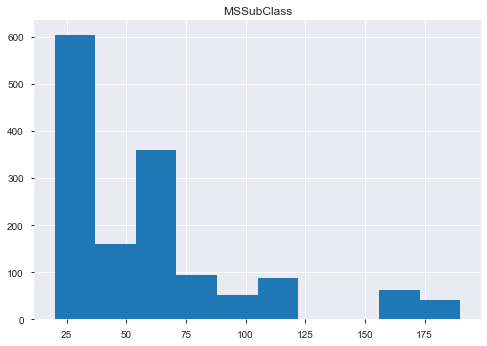

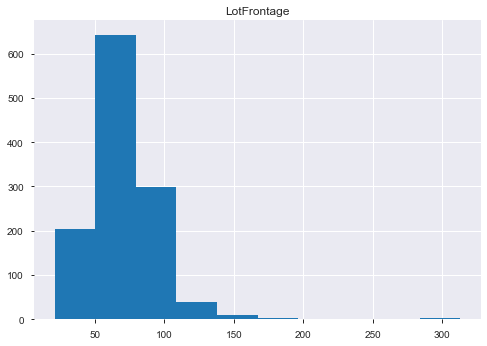

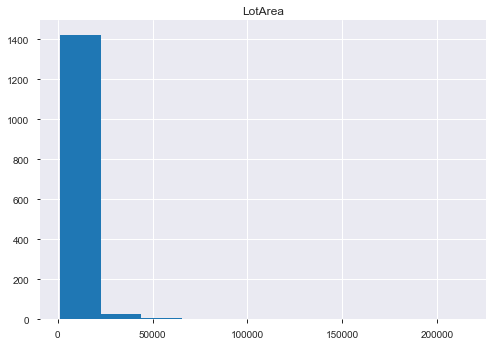

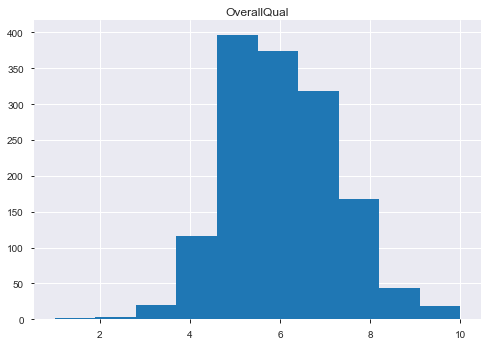

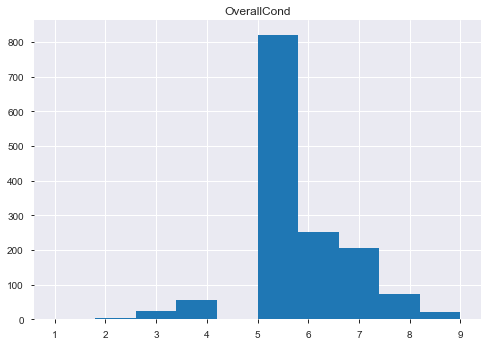

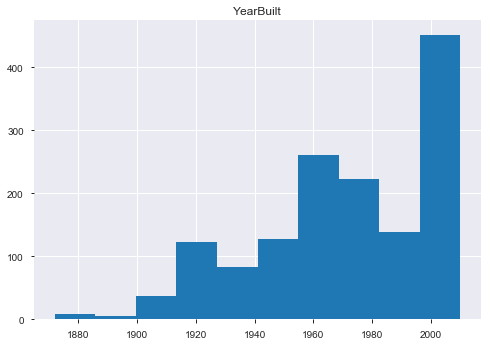

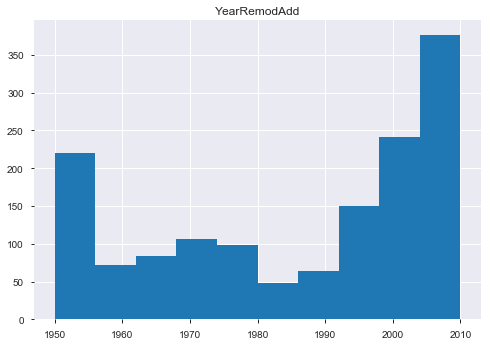

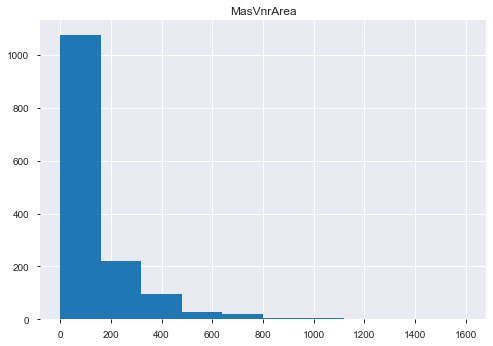

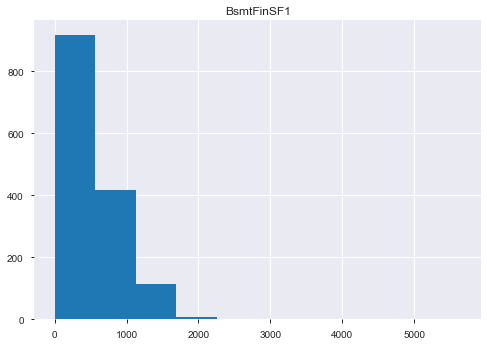

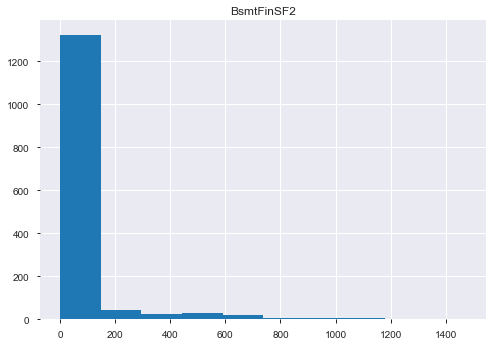

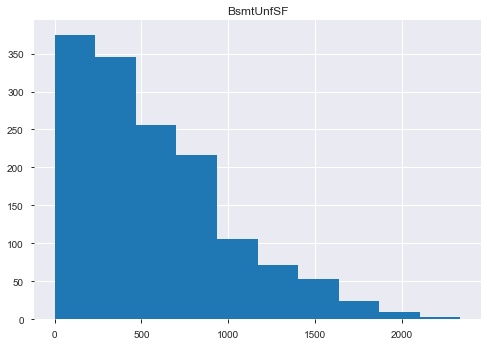

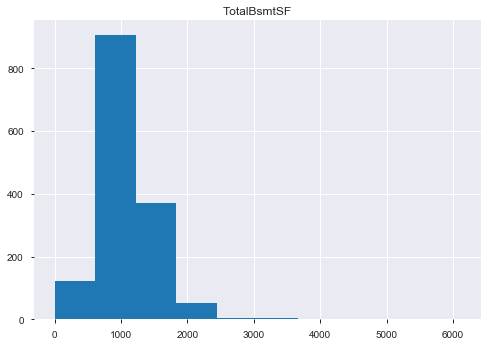

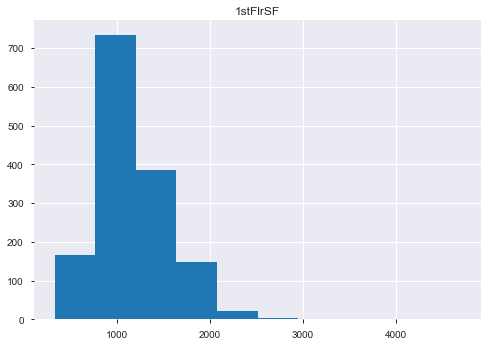

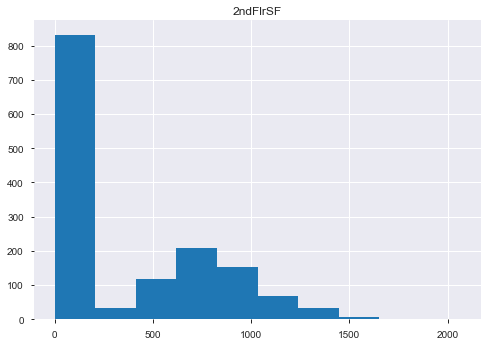

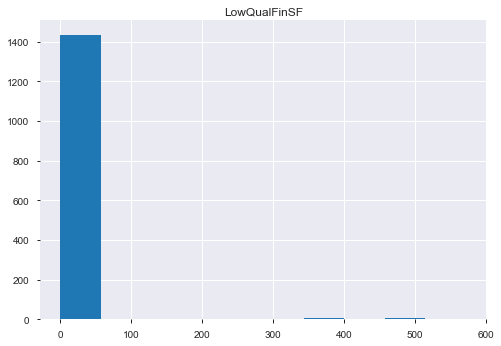

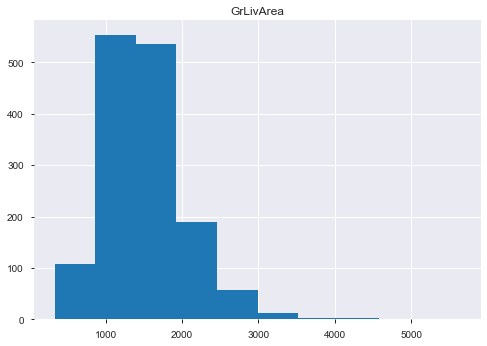

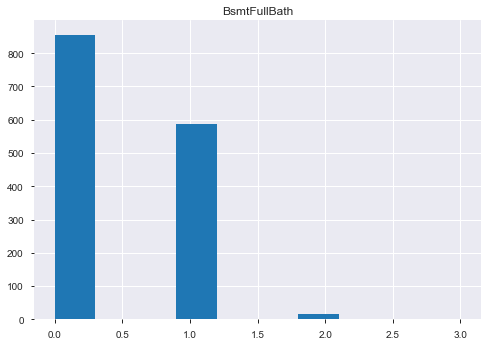

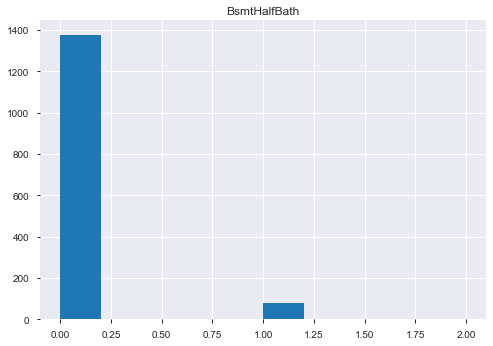

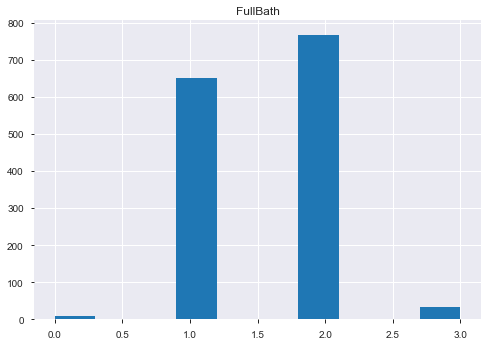

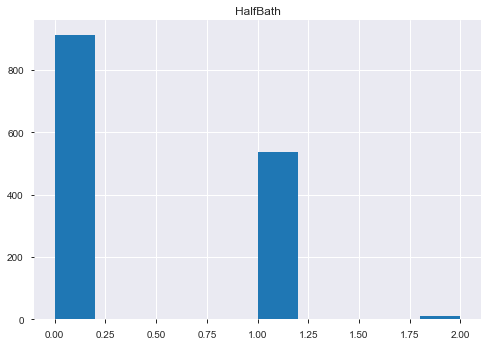

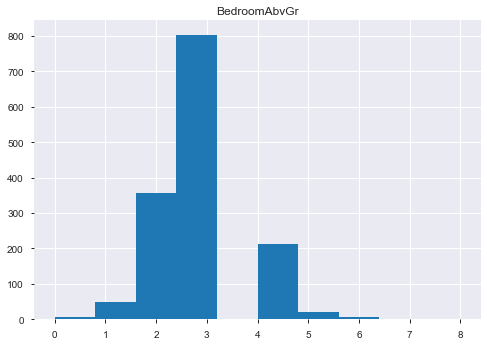

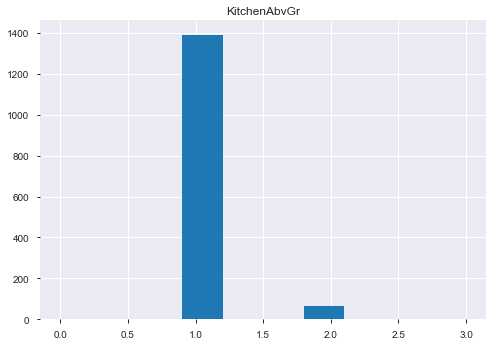

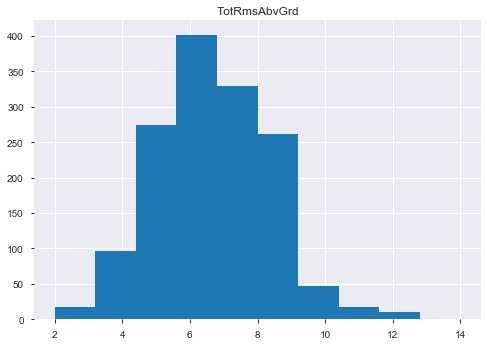

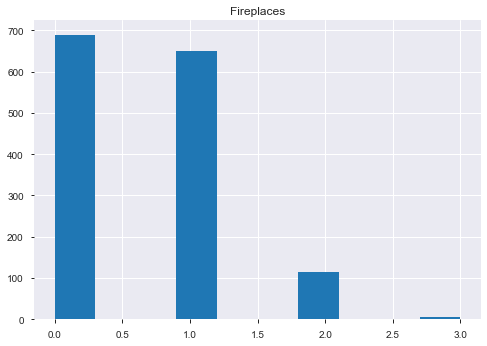

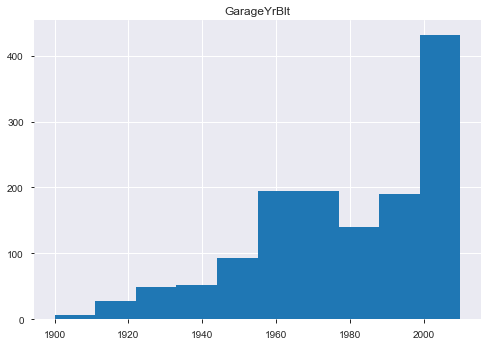

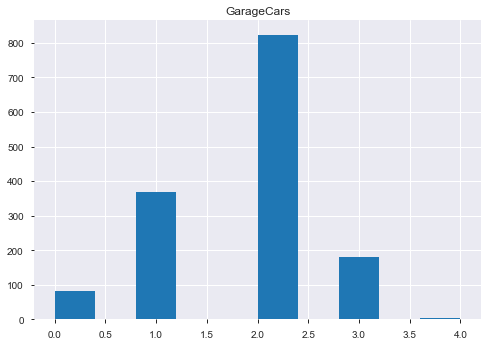

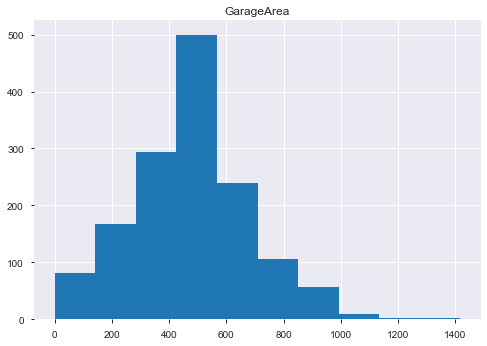

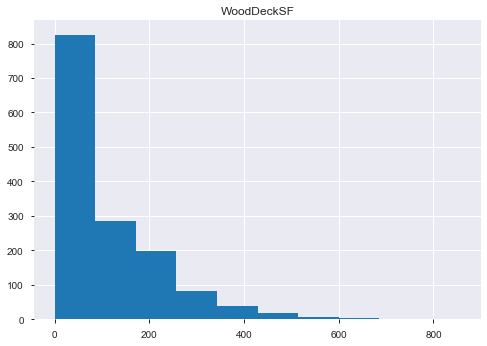

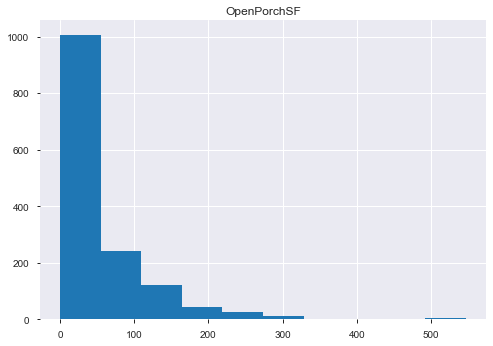

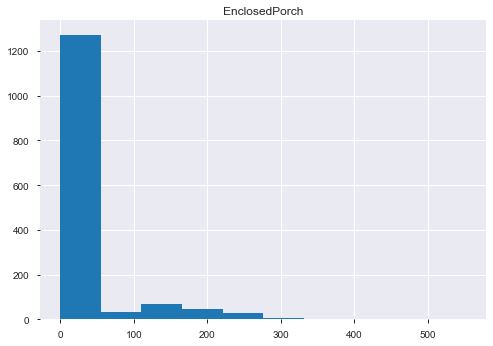

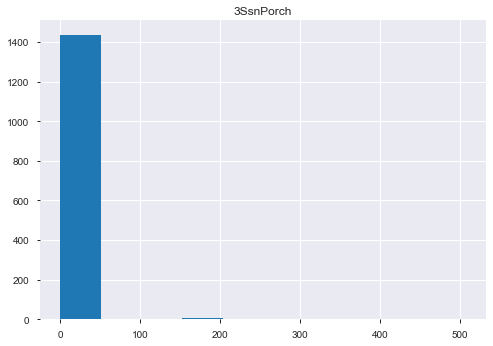

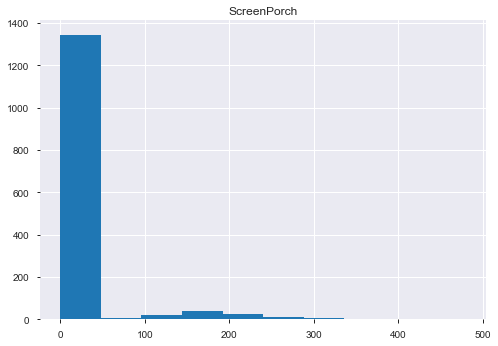

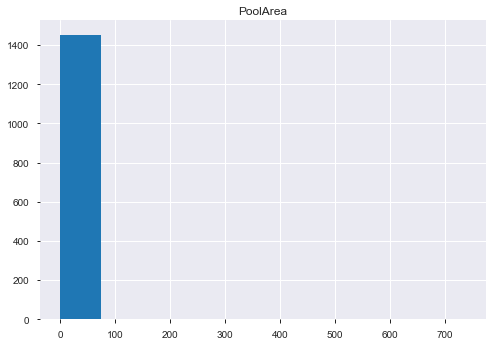

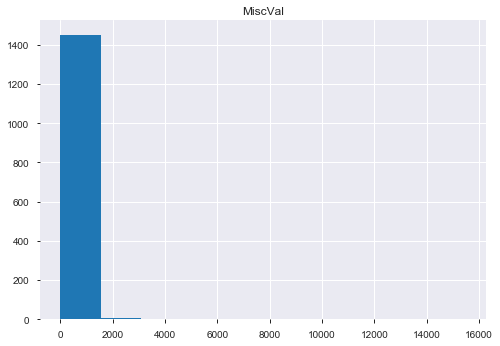

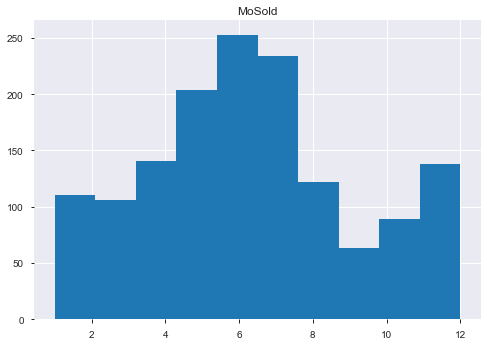

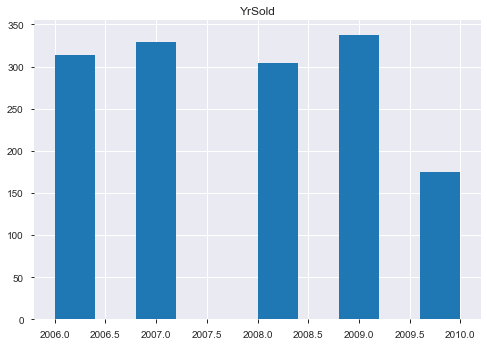

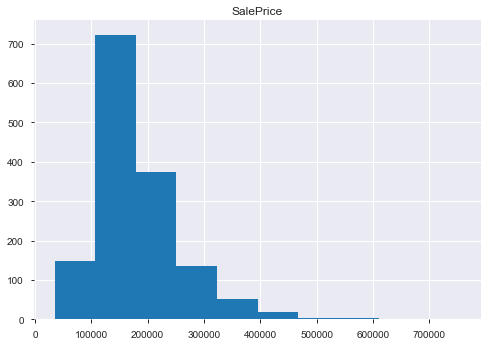

In [67]:
#Visualize numerical data
for column in df_train.columns:
    if df_train[column].dtype!="object":
        plt.figure()
        plt.hist(df_train[column])
        plt.title(column)
        plt.show()
        plt.close()

In [68]:
#Impute values for numerical NA values
df_train['LotFrontage_na']=df_train['LotFrontage'].isna().astype("int")
df_train.LotFrontage=df_train.LotFrontage.fillna(0)
df_train.MasVnrArea=df_train.MasVnrArea.fillna(0)
df_train.GarageYrBlt[df_train.GarageYrBlt.isna()]=df_train.YearRemodAdd[df_train.GarageYrBlt.isna()]

In [69]:
df_train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,LotFrontage_na
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,0
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,0
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,0
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,0
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,0
5,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,...,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000,0
6,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,8,2007,WD,Normal,307000,0
7,60,RL,0.0,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,...,NaN,NaN,Shed,350,11,2009,WD,Normal,200000,1
8,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900,0
9,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,...,NaN,NaN,NaN,0,1,2008,WD,Normal,118000,0


In [38]:
df_train.GarageYrBlt


0       2003.0
1       1976.0
2       2001.0
3       1998.0
4       2000.0
5       1993.0
6       2004.0
7       1973.0
8       1931.0
9       1939.0
10      1965.0
11      2005.0
12      1962.0
13      2006.0
14      1960.0
15      1991.0
16      1970.0
17      1967.0
18      2004.0
19      1958.0
20      2005.0
21      1930.0
22      2002.0
23      1976.0
24      1968.0
25      2007.0
26      2005.0
27      2008.0
28      1957.0
29      1920.0
30      1920.0
31      1966.0
32      2007.0
33      1959.0
34      2005.0
35      2004.0
36      1995.0
37      1954.0
38      1953.0
39      1955.0
40      1965.0
41      1959.0
42      1983.0
43      1977.0
44      1959.0
45      2005.0
46      2003.0
47      2006.0
48      2008.0
49      1966.0
50      1997.0
51      1985.0
52      1963.0
53      1981.0
54      1962.0
55      1964.0
56      1999.0
57      2004.0
58      2006.0
59      1973.0
60      2006.0
61      1935.0
62      2006.0
63      1990.0
64      1998.0
65      2004.0
66      19

In [70]:
df_explode=pd.get_dummies(df_train,dummy_na=True)
df_explode

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,65.0,8450,7,5,2003,2003,65.0,706,0,150,...,0,1,0,0,0,0,0,1,0,0
1,80.0,9600,6,8,1976,1976,80.0,978,0,284,...,0,1,0,0,0,0,0,1,0,0
2,68.0,11250,7,5,2001,2002,68.0,486,0,434,...,0,1,0,0,0,0,0,1,0,0
3,60.0,9550,7,5,1915,1970,60.0,216,0,540,...,0,1,0,1,0,0,0,0,0,0
4,84.0,14260,8,5,2000,2000,84.0,655,0,490,...,0,1,0,0,0,0,0,1,0,0
5,85.0,14115,5,5,1993,1995,85.0,732,0,64,...,0,1,0,0,0,0,0,1,0,0
6,75.0,10084,8,5,2004,2005,75.0,1369,0,317,...,0,1,0,0,0,0,0,1,0,0
7,0.0,10382,7,6,1973,1973,0.0,859,32,216,...,0,1,0,0,0,0,0,1,0,0
8,51.0,6120,7,5,1931,1950,51.0,0,0,952,...,0,1,0,1,0,0,0,0,0,0
9,50.0,7420,5,6,1939,1950,50.0,851,0,140,...,0,1,0,0,0,0,0,1,0,0


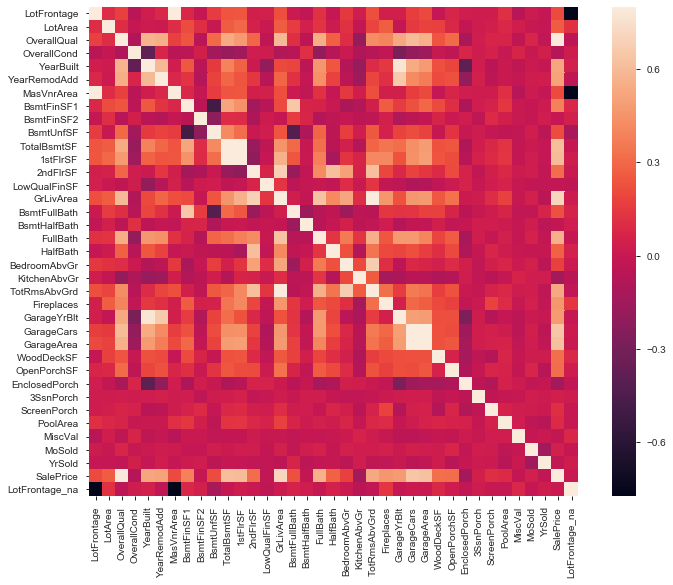

In [71]:
import seaborn as sns
#correlation matrix
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [97]:
df_train

In [65]:
r=pd.DataFrame([regr.feature_importances_.tolist(),list(X.columns)])
#sorted(r,reverse=True)
r=r.T

In [66]:
print(sum(r[0]))

r=r.sort_values(0,ascending=False)
r[2]=r[0].cumsum()
r

1.0000000000000004


,0,1,2
2,0.586818,OverallQual,0.586818
14,0.106415,GrLivArea,0.693232
10,0.0372984,TotalBsmtSF,0.730531
12,0.0285515,2ndFlrSF,0.759082
7,0.0284026,BsmtFinSF1,0.787485
11,0.0261598,1stFlrSF,0.813645
24,0.0223415,GarageCars,0.835986
25,0.0147805,GarageArea,0.850767
1,0.0128066,LotArea,0.863573
4,0.00896304,YearBuilt,0.872536


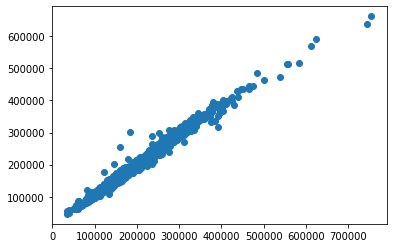

In [167]:
y_preds = regr.predict(X)
y_preds
plt.plot(y, y_preds,'o')

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   3.,   0.,   0.,   0.,   1.,
          0.,   0.,   1.,   1.,   0.,   1.,   1.,   1.,   4.,   8.,   4.,
          9.,  33.,  29.,  41.,  68.,  86., 160., 213., 235., 194., 108.,
         81.,  39.,  34.,  27.,  14.,  16.,  11.,   4.,   3.,   4.,   5.,
          1.,   2.,   2.,   1.,   2.,   5.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          1.]), array([-117639.74  , -115391.8503, -113143.9606, -110896.0709,
        -108648.1812, -106400.2915, -104152.4018, -101904.5121,
         -99656.6224,  -97408.7327,  -95160.843 ,  -92912.9533,
         -90665.0636,  -88417.1739,  -86169.2842,  -83921.3945,
         -81673.5048,  -79425.6151,  -77177.7254,  -74929.8357,

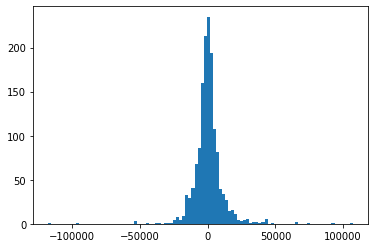

In [169]:
plt.hist(y-y_preds,100)

In [107]:


kf = KFold(n_splits=5)
kf.get_n_splits(X)

print(kf)
scaler = StandardScaler()
alpha_range=[.0001,.001, .005, .01]
for alpha in alpha_range:
    print(alpha)
    for train_index, test_index in kf.split(X):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X.loc[train_index,:], X.loc[test_index,:]
        y_train, y_test = y[train_index], y[test_index]
        scaler.fit(X_train)
        scaler.transform(X_test)
        lasso = Lasso(alpha=alpha, max_iter=3000)
        lasso.fit(scaler.transform(X_train), np.log(y_train))
        y_pred=lasso.predict(scaler.transform(X_test))
        print(np.sqrt(metrics.mean_squared_error(y_test,np.exp(y_pred))))

KFold(n_splits=5, random_state=None, shuffle=False)
0.0001
22001.059314597594
47950.188907636584
30214.944199388796
18853.96530227066
112782.07634047561
0.001
20441.877667061617
49163.41988669271
29406.04700816962
18292.719243266158
111202.71557837528
0.005
19366.597113637123
49786.66448740551
28601.896902608387
19480.29892653517
110925.72204015734
0.01
20662.473609158664
48430.44203162988
29692.384024145136
21277.389950784913
118712.28711521703


In [110]:
pd.DataFrame(zip(lasso.coef_,X.columns))

,0,1
0,0.000000,LotFrontage
1,0.015994,LotArea
2,0.094640,OverallQual
3,0.025495,OverallCond
4,0.035816,YearBuilt
5,0.029213,YearRemodAdd
6,0.000000,MasVnrArea
7,0.028611,BsmtFinSF1
8,0.000000,BsmtFinSF2
9,-0.000000,BsmtUnfSF


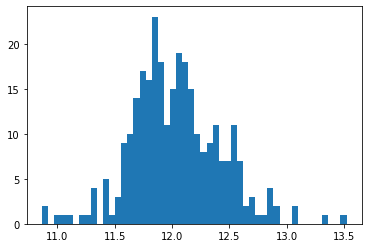

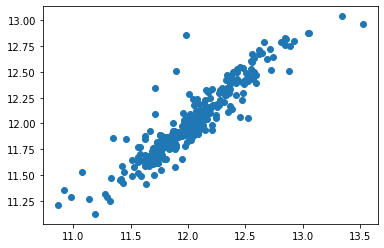

In [94]:
plt.hist(np.log(y_test),50)
plt.figure()
plt.plot(np.log(y_test),y_pred,'o')

In [83]:
scaler.fit(X_train)
scaler.transform(X_train)

array([[ 0.21656877, -0.19407633,  0.65264239, ...,  0.47768281,
        -0.3093296 ,  0.        ],
       [ 0.65618004, -0.08633823, -0.07334457, ...,  0.47768281,
        -0.3093296 ,  0.        ],
       [ 0.30449102,  0.06824252,  0.65264239, ...,  0.47768281,
        -0.3093296 ,  0.        ],
       ...,
       [ 0.62687262, -0.09186566,  0.65264239, ..., -2.09343939,
         3.23279761,  0.        ],
       [ 0.18726135, -0.00436359,  1.37862936, ...,  0.47768281,
        -0.3093296 ,  0.        ],
       [ 0.01141685,  0.03095577, -0.07334457, ...,  0.47768281,
        -0.3093296 ,  0.        ]])

In [57]:


kf = KFold(n_splits=5)
kf.get_n_splits(X)

print(kf)
scaler = StandardScaler()
for max_depth in range(2,20,2):
    print(max_depth)
    for train_index, test_index in kf.split(X):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X.loc[train_index,:], X.loc[test_index,:]
        y_train, y_test = y[train_index], y[test_index]
        scaler.fit(X_train)
        scaler.transform(X_test)
        regr = RandomForestRegressor(max_depth=max_depth, random_state=0)
        regr.fit(scaler.transform(X_train), np.log(y_train))
        y_pred=regr.predict(scaler.transform(X_test))
        print(np.sqrt(metrics.mean_squared_error(y_test),np.exp(y_pred)))

NameError: name 'X' is not defined